# Analysis to pick the best token length for SAUR cohort

## Read bed files containing tokens

In [1]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'SAUR')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,0,6,TTTTCTT,0.000064,ALF22G140
1,1,7,9,ACC,-0.000395,ALF22G140
2,1,10,13,GACA,0.001573,ALF22G140
3,1,14,18,AGAAT,-0.000986,ALF22G140
4,1,19,25,TAATTAT,0.000795,ALF22G140
...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044
176721939,5,181674,181676,GCA,-0.003468,AH21C044
176721940,5,181677,181680,TCCA,-0.000228,AH21C044


## Calculate token lengths

In [2]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,0,6,TTTTCTT,0.000064,ALF22G140,7
1,1,7,9,ACC,-0.000395,ALF22G140,3
2,1,10,13,GACA,0.001573,ALF22G140,4
3,1,14,18,AGAAT,-0.000986,ALF22G140,5
4,1,19,25,TAATTAT,0.000795,ALF22G140,7
...,...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044,3
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044,6
176721939,5,181674,181676,GCA,-0.003468,AH21C044,3
176721940,5,181677,181680,TCCA,-0.000228,AH21C044,4


## Generate with and without signature files for different token lengths

In [3]:
import os

from pathlib import Path


for tokenLength in range(5, 13):
    print('tokenLength: ', tokenLength)
    tokensDf = bedDf[bedDf.token_length > tokenLength]
    highscoreTokens = list(tokensDf.sort_values(by=['score'], ascending=False).tokens.unique()[:10])
    groupedDf = tokensDf[tokensDf.tokens.isin(highscoreTokens)].groupby(by=['tube_id'])['tokens'].nunique().reset_index().rename(columns={'tokens': 'unique_token_count'})
    uniqueTokenCountCountsDf = groupedDf.unique_token_count.value_counts().reset_index().sort_values(by=['unique_token_count'], ascending=False)
    uniqueTokenCountCountsDf['cumulative_count'] = uniqueTokenCountCountsDf['count'].cumsum()
    uniqueTokenCountCountsDf['cumulative_proportion'] = uniqueTokenCountCountsDf['cumulative_count']/uniqueTokenCountCountsDf['count'].sum()
    uniqueTokenCountCountsDf = uniqueTokenCountCountsDf.sort_values(by=['cumulative_proportion'])
    print('uniqueTokenCountCountsDf: ', uniqueTokenCountCountsDf)
    countCutoff = int(uniqueTokenCountCountsDf[(uniqueTokenCountCountsDf.cumulative_proportion > 0.2)][:1].unique_token_count.values[0])
    print('countCutoff: ', countCutoff)
    withoutSignatureDf = groupedDf[groupedDf.unique_token_count < countCutoff]
    print('without signature: ', withoutSignatureDf.shape[0])
    withSignatureDf = groupedDf[groupedDf.unique_token_count >= countCutoff]
    print('with signature: ', withSignatureDf.shape[0])
    withoutSignatureDf.tube_id.to_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'SAUR', 'tl_' + str(tokenLength) + '_wos_tubeids.txt'), index=False)
    withSignatureDf.tube_id.to_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'SAUR', 'tl_' + str(tokenLength) + '_ws_tubeids.txt'), index=False)

tokenLength:  5
uniqueTokenCountCountsDf:     unique_token_count  count  cumulative_count  cumulative_proportion
0                  10    557               557                    1.0
countCutoff:  10
without signature:  0
with signature:  557
tokenLength:  6
uniqueTokenCountCountsDf:     unique_token_count  count  cumulative_count  cumulative_proportion
0                  10    557               557                    1.0
countCutoff:  10
without signature:  0
with signature:  557
tokenLength:  7
uniqueTokenCountCountsDf:     unique_token_count  count  cumulative_count  cumulative_proportion
0                  10    541               541               0.971275
1                   9     16               557               1.000000
countCutoff:  10
without signature:  16
with signature:  541
tokenLength:  8
uniqueTokenCountCountsDf:     unique_token_count  count  cumulative_count  cumulative_proportion
0                  10    503               503               0.903052
1                

## Run log rank test

In [4]:
import os

from pathlib import Path

import pandas as pd

from lifelines.utils import datetimes_to_durations

from lifelines.statistics import logrank_test


rows = []

journeysDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'data', 'full_cohort', 'journry_times.csv'))
mappingDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'patient_tube_id_mapping_full.tsv'), sep='\t')[['tube_code', 'PATIENT_ID']].drop_duplicates()
mergedDf = journeysDf.merge(
    mappingDf,
    how='inner',
    left_on='person_id',
    right_on='PATIENT_ID'
).drop(columns=['PATIENT_ID'])


for tokenLength in range(5, 13):
    withoutSignatureTubeidsDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'SAUR', 'tl_' + str(tokenLength) + '_wos_tubeids.txt'))
    withoutSignatureDf = mergedDf.merge(
        withoutSignatureTubeidsDf,
        how='inner',
        left_on=['tube_code'],
        right_on=['tube_id']
    )
    withoutSignatureDf['cohort'] = 'Without Signature'
    withSignatureTubeidsDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'SAUR', 'tl_' + str(tokenLength) + '_ws_tubeids.txt'))
    withSignatureDf = mergedDf.merge(
        withSignatureTubeidsDf,
        how='inner',
        left_on=['tube_code'],
        right_on=['tube_id']
    )
    withSignatureDf['cohort'] = 'With Signature'
    conbinedDf = pd.concat([withoutSignatureDf, withSignatureDf], ignore_index=True)

    T, E = datetimes_to_durations(conbinedDf.admittime_adm, conbinedDf.deathtime_adm, freq='D', dayfirst=True)

    conbinedDf['T'] = T
    conbinedDf['E'] = E

    for duration in list(range(30, 150, 30)) + list(range(150, 500, 50)) + list(range(500, 1500, 100)) + list(range(1500, 2500, 200)):

        filteredDf = conbinedDf[(conbinedDf['T'] > 0) & (conbinedDf['T'] < duration)]

        results = logrank_test(
            filteredDf[(filteredDf.cohort == 'With Signature')]['T'],
            filteredDf[(filteredDf.cohort == 'Without Signature')]['T'],
            event_observed_A=filteredDf[(filteredDf.cohort == 'With Signature')]['E'],
            event_observed_B=filteredDf[(filteredDf.cohort == 'Without Signature')]['E'],
            )

        rows.append([tokenLength, duration, results.p_value])
plotDf = pd.DataFrame(rows, columns=['token length', 'journey duration', 'p value'])
plotDf

,token length,journey duration,p value
0,5,30,NaN
1,5,60,NaN
2,5,90,NaN
3,5,120,NaN
4,5,150,NaN
...,...,...,...
203,12,1500,0.196453
204,12,1700,0.287821
205,12,1900,0.493495
206,12,2100,0.825330


## Visualise p-values

### For different token lengths

<Axes: xlabel='journey duration', ylabel='p value'>

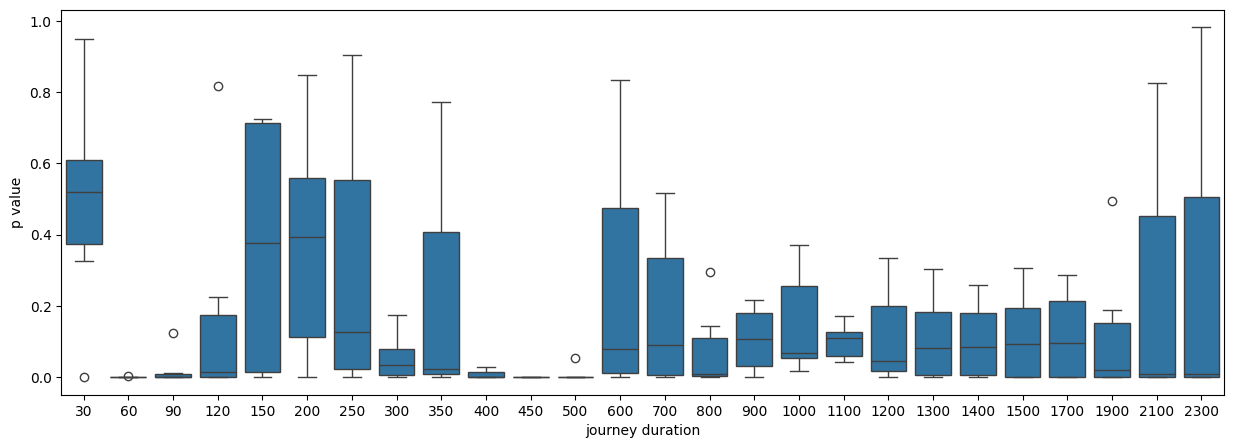

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns


f, ax = plt.subplots(1, 1, figsize=(15, 5))

sns.boxplot(data=plotDf, x='journey duration', y='p value')

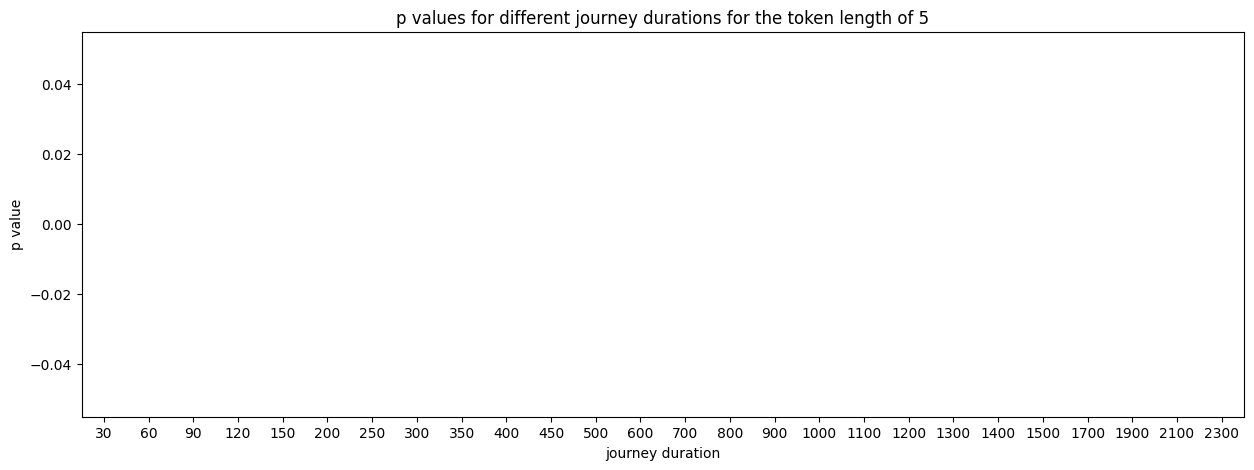

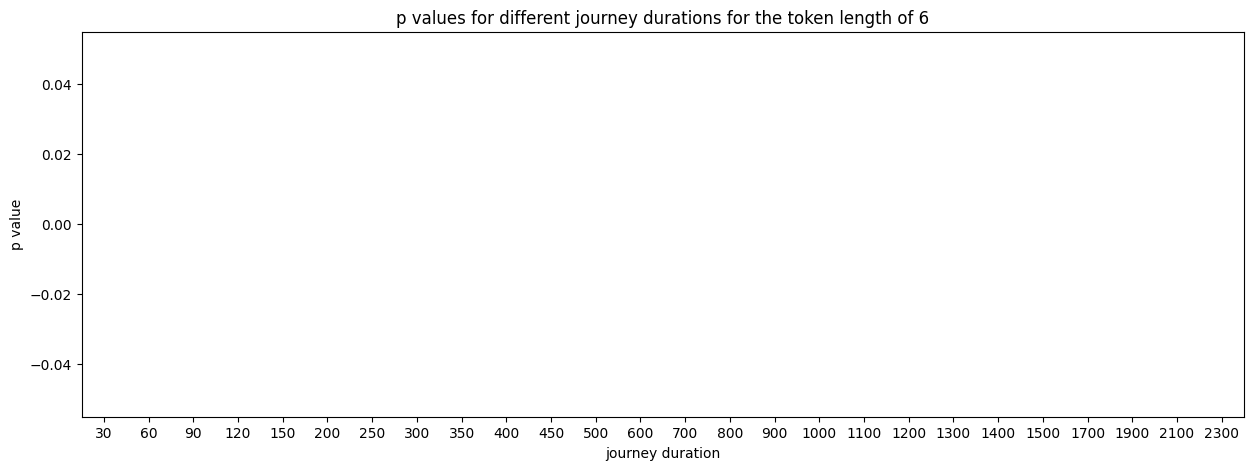

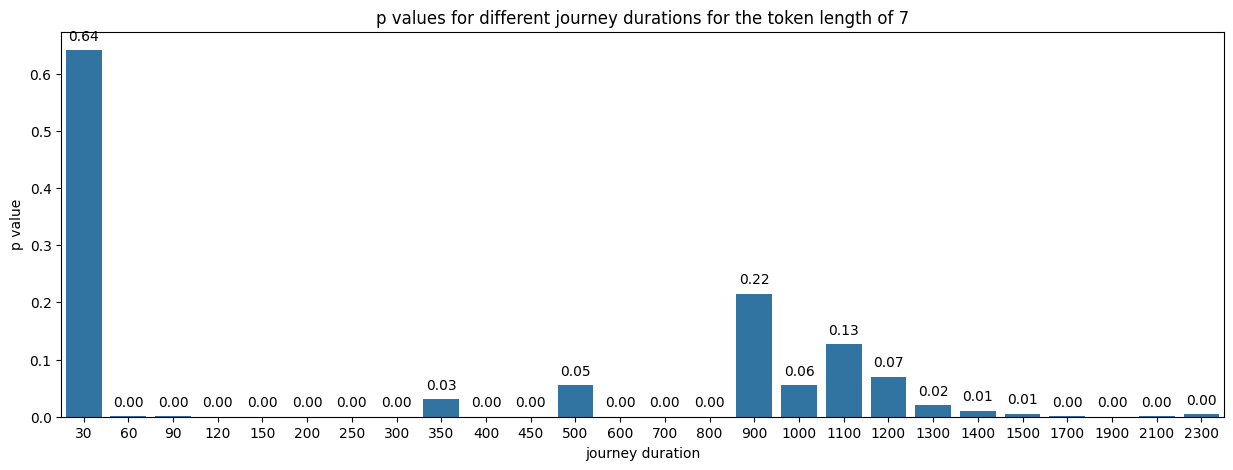

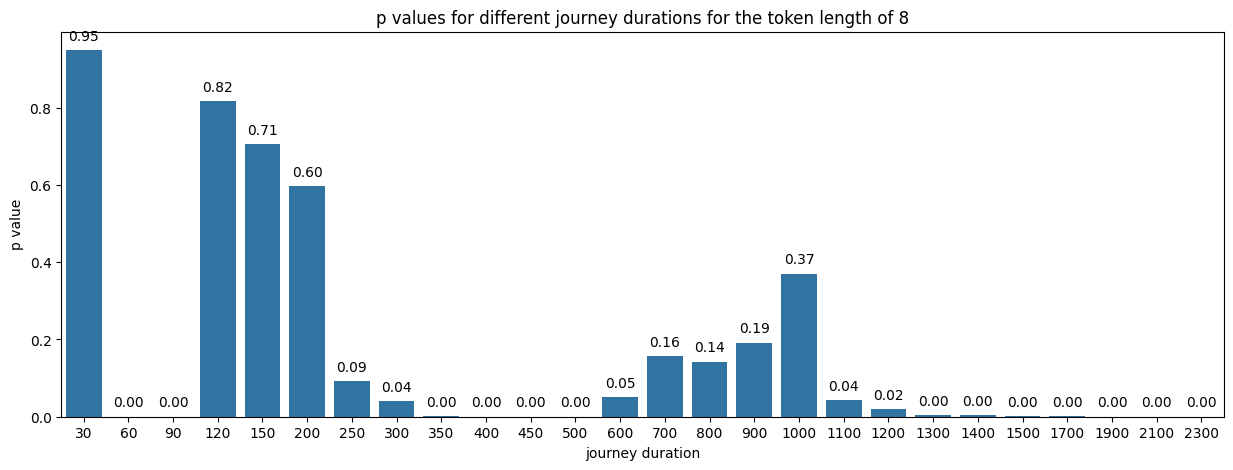

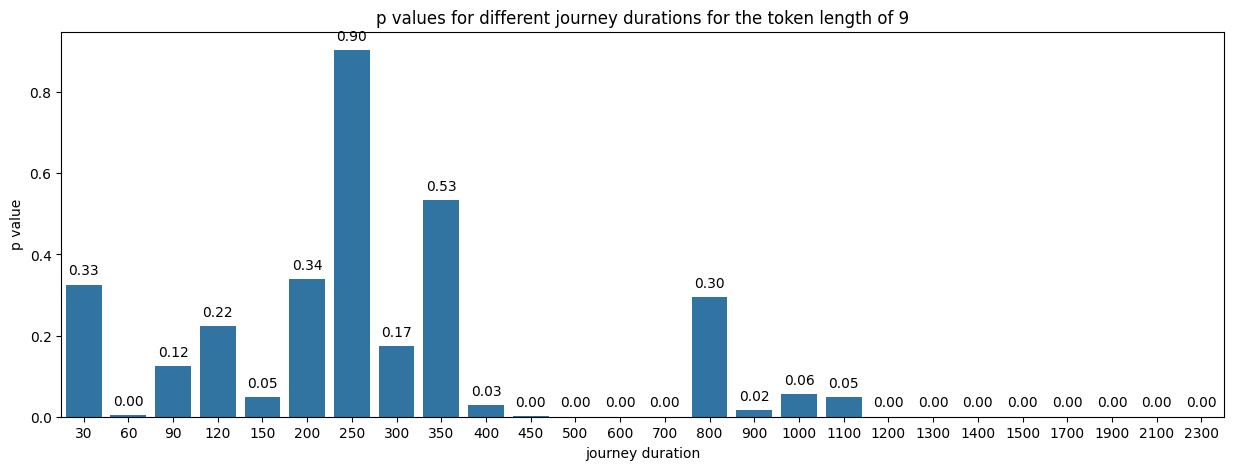

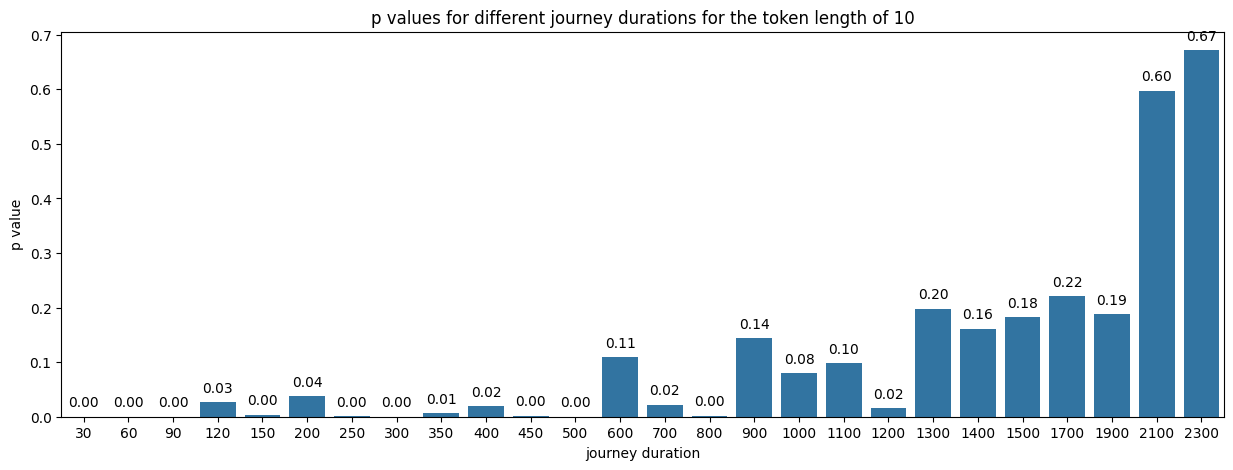

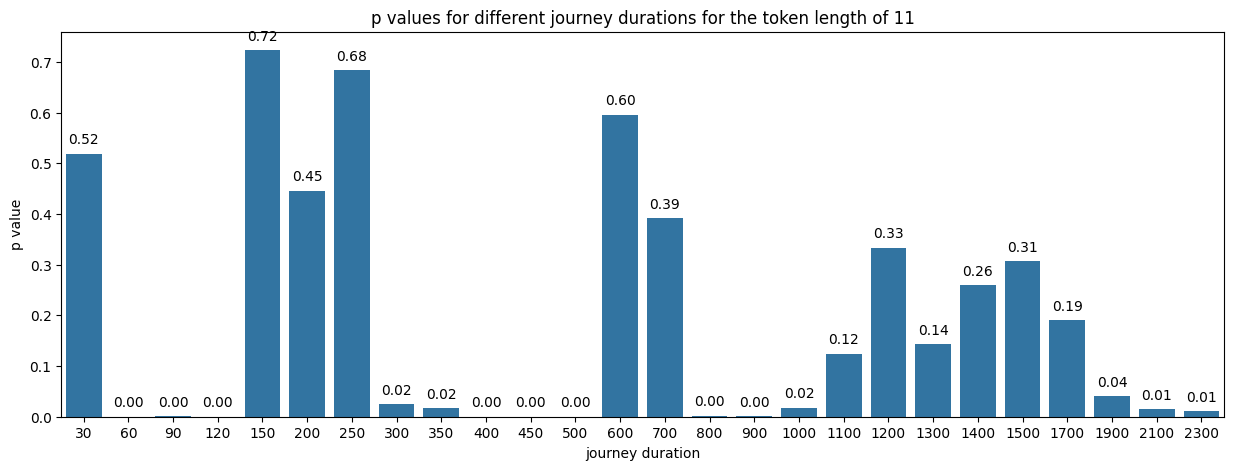

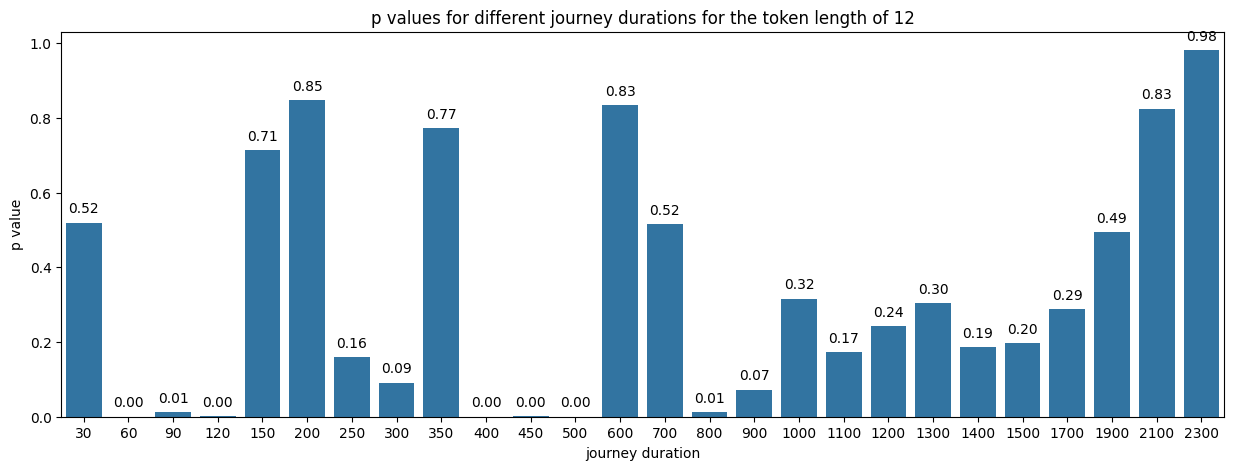

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns


for tokenLength in range(5, 13):
    f, ax = plt.subplots(1, 1, figsize=(15, 5))

    sns.barplot(plotDf[plotDf['token length'] == tokenLength], x='journey duration', y='p value',  ax=ax)

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    ax.set_title('p values for different journey durations for the token length of ' + str(tokenLength))

    plt.show()

### For different journey durations

<Axes: xlabel='token length', ylabel='p value'>

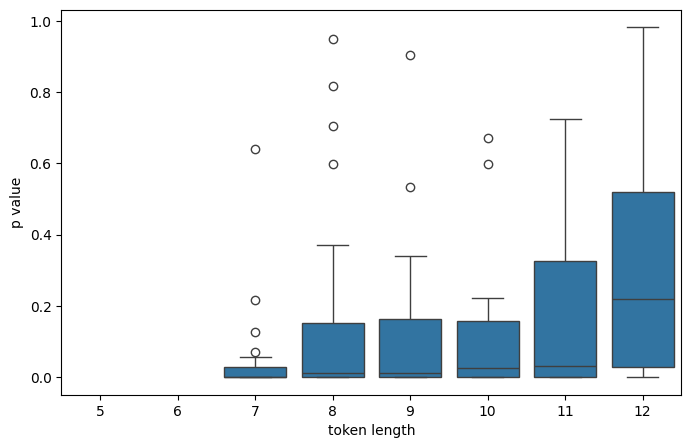

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns


f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.boxplot(data=plotDf, x='token length', y='p value')

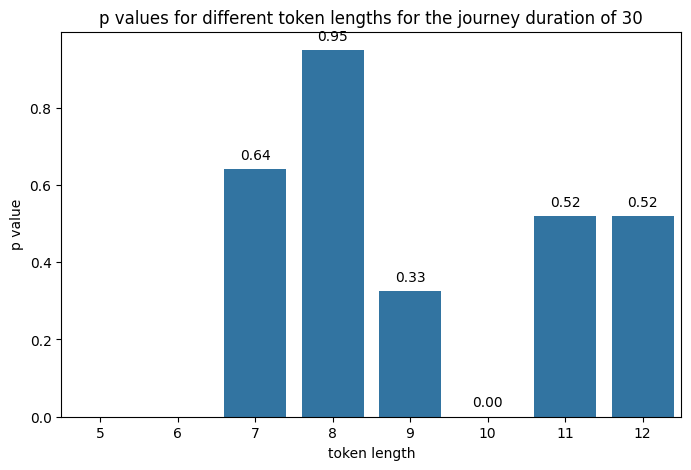

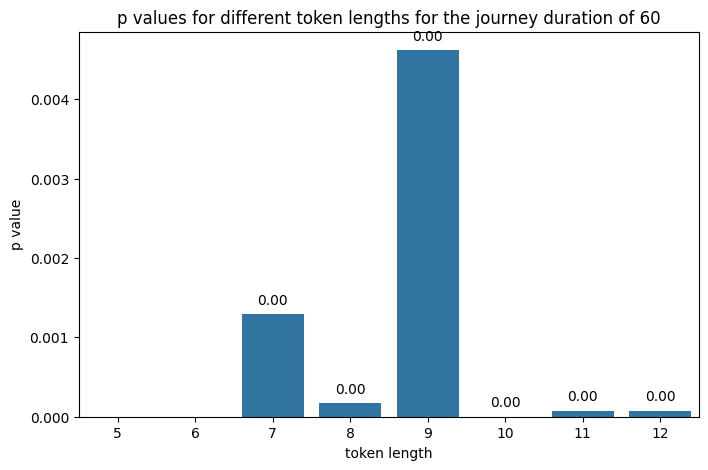

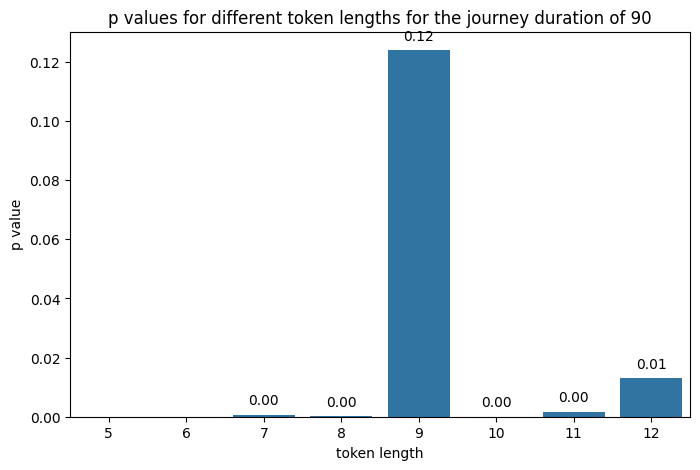

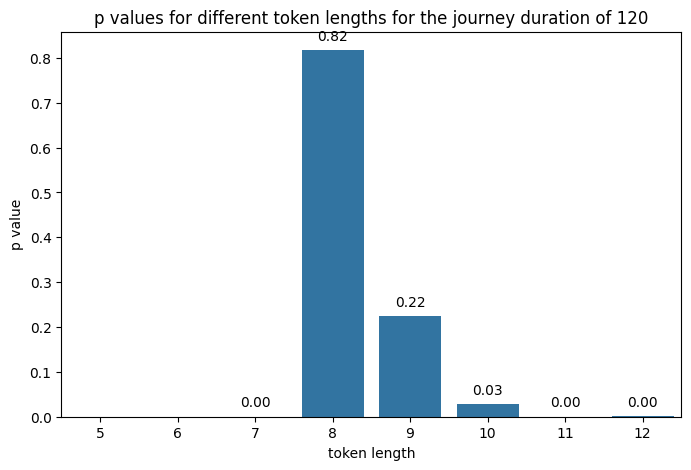

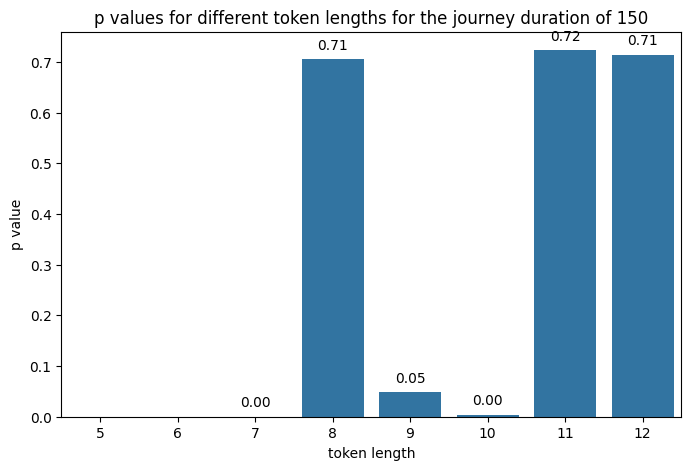

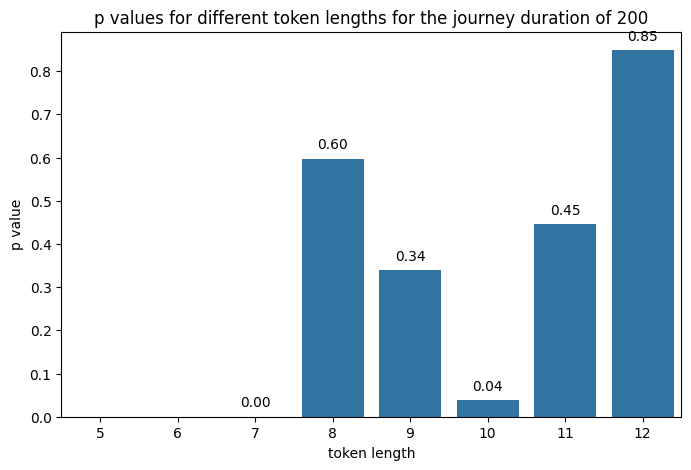

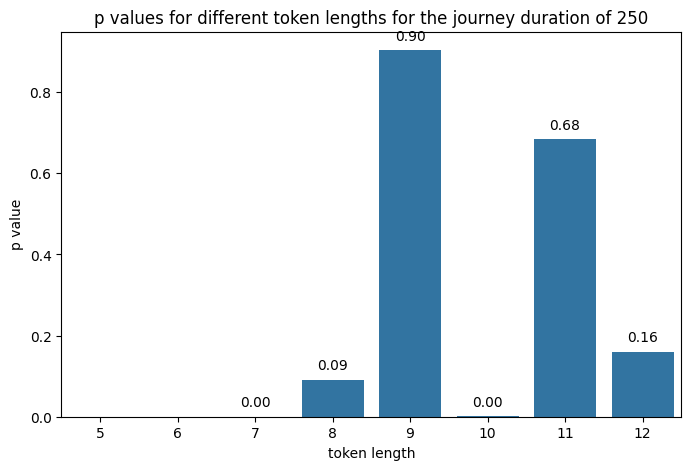

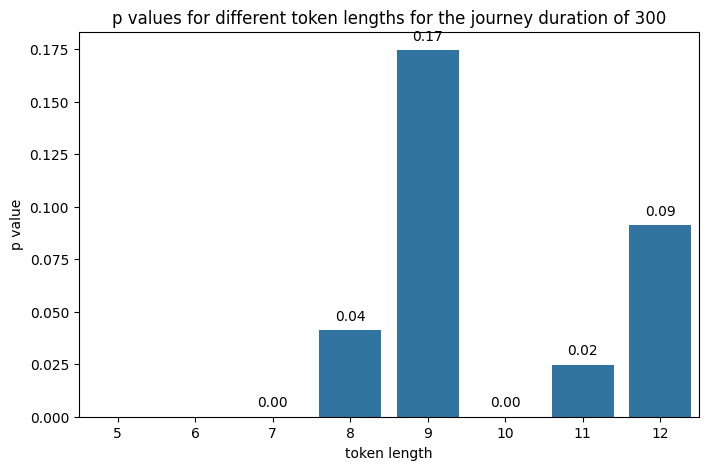

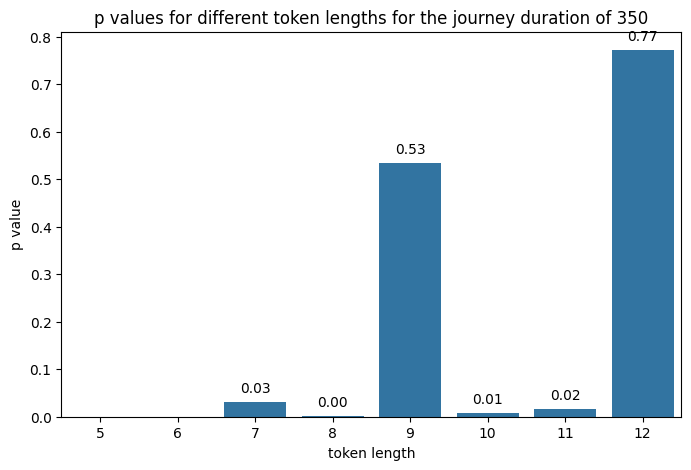

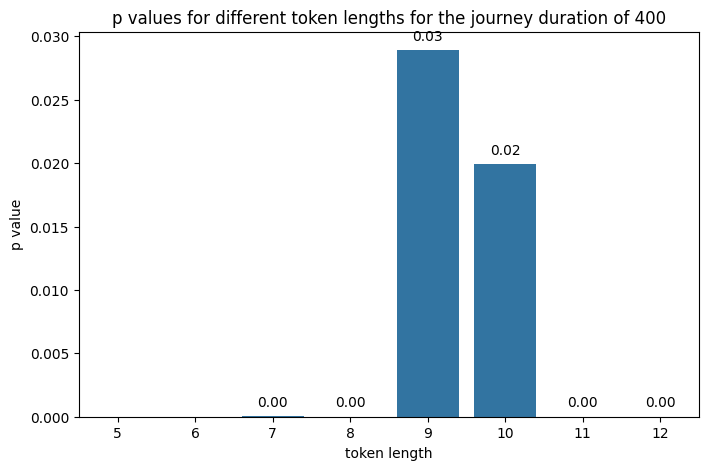

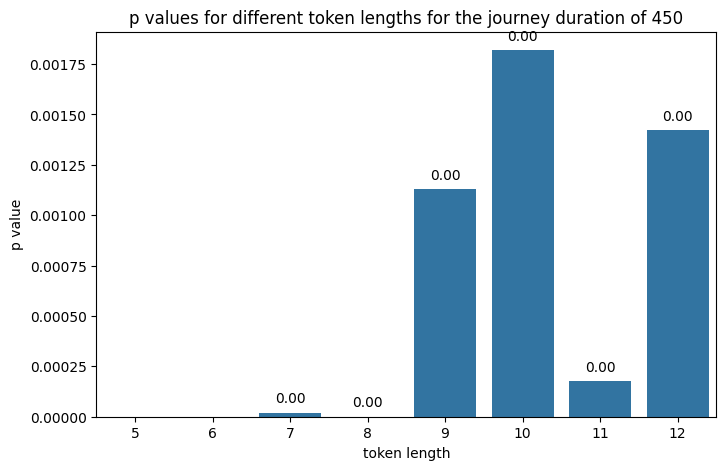

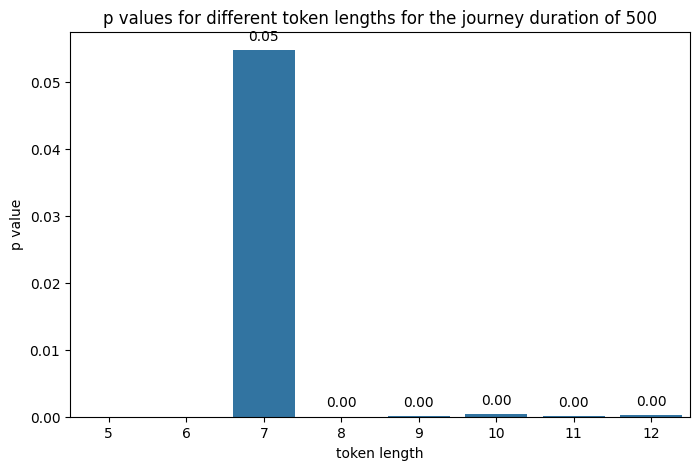

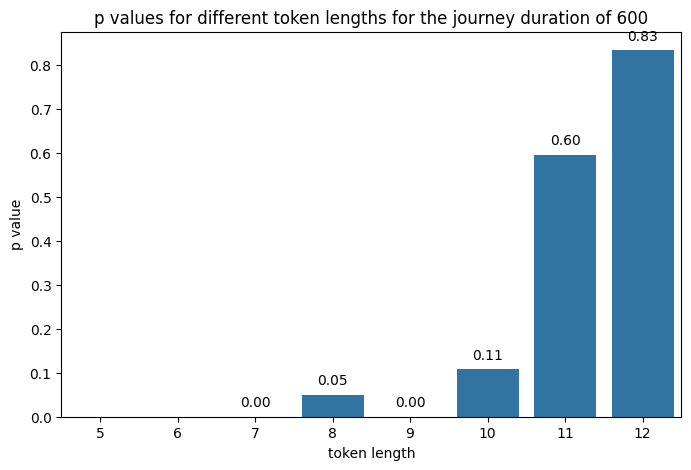

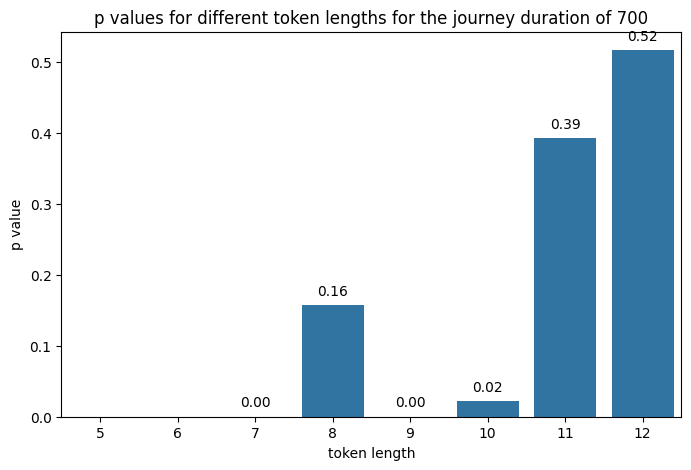

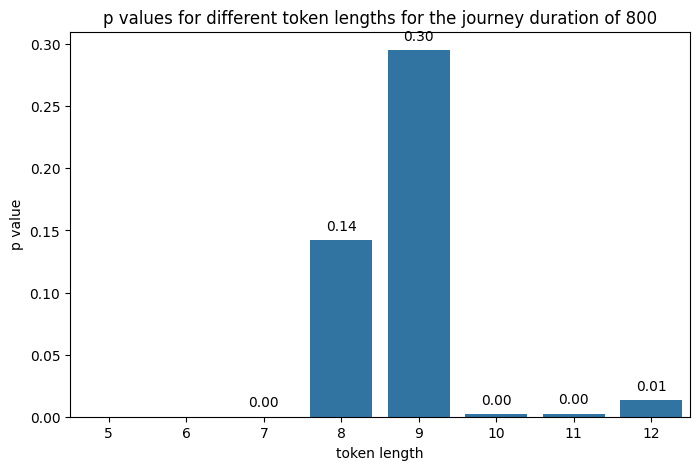

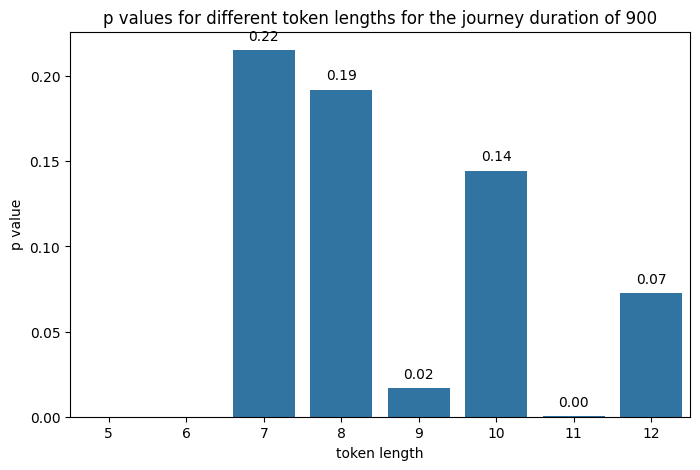

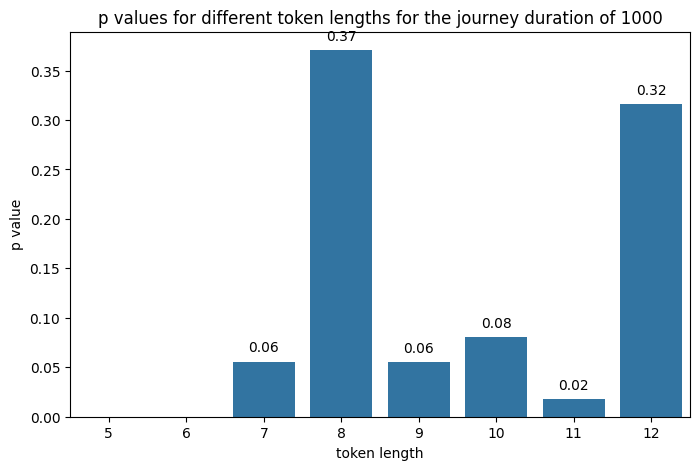

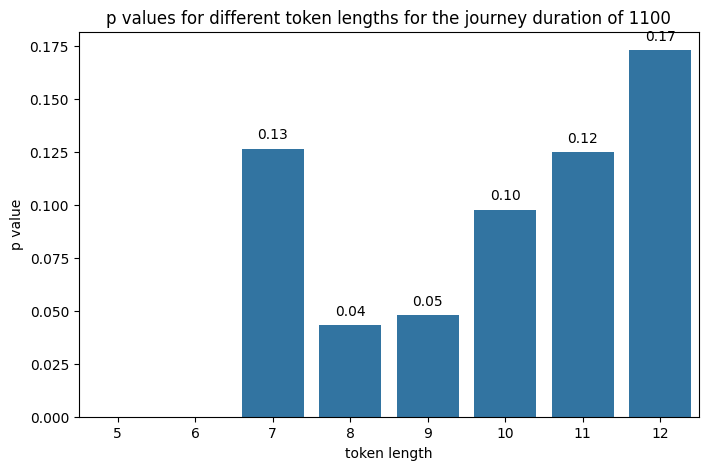

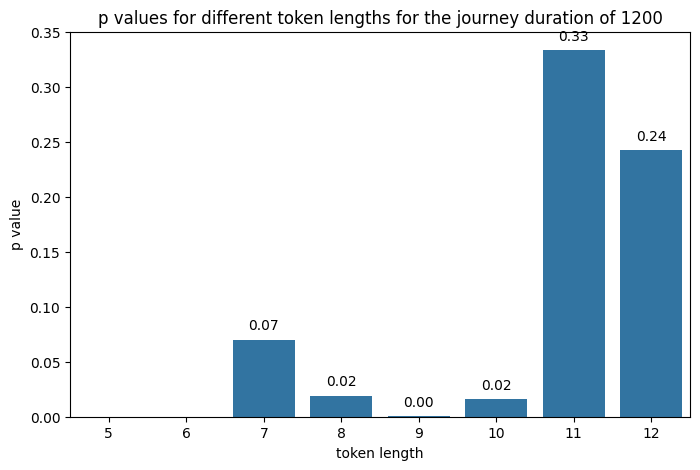

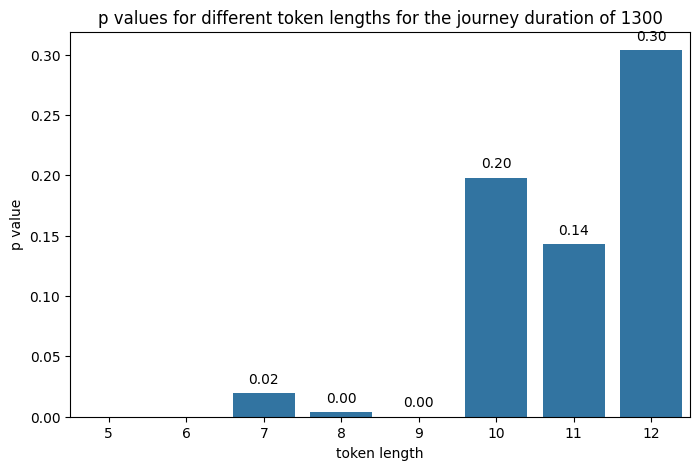

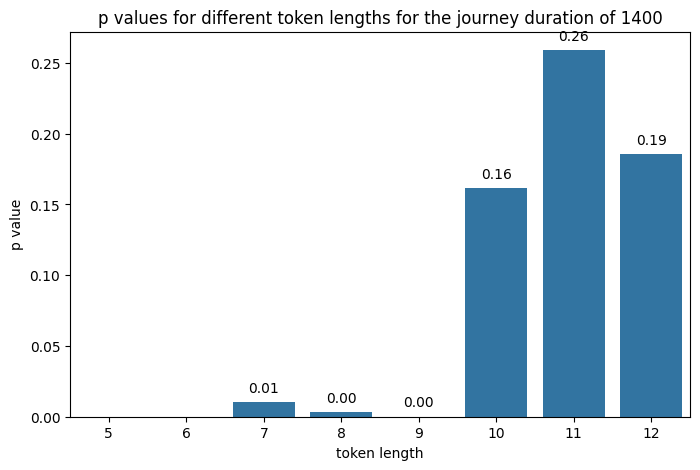

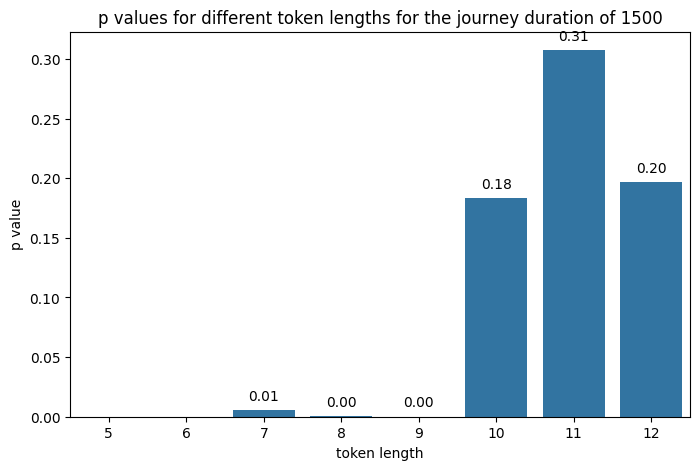

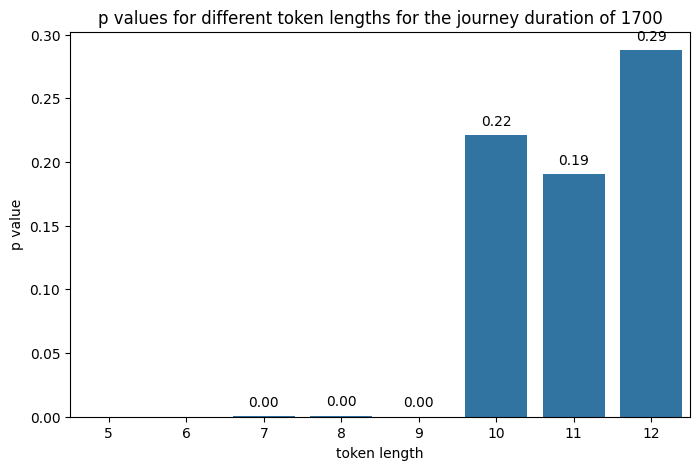

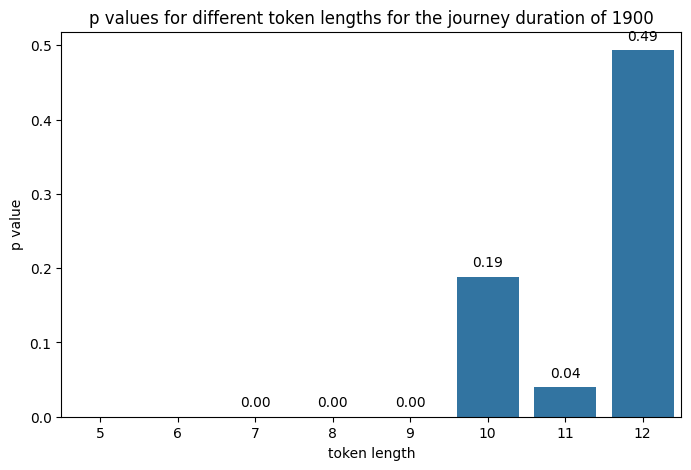

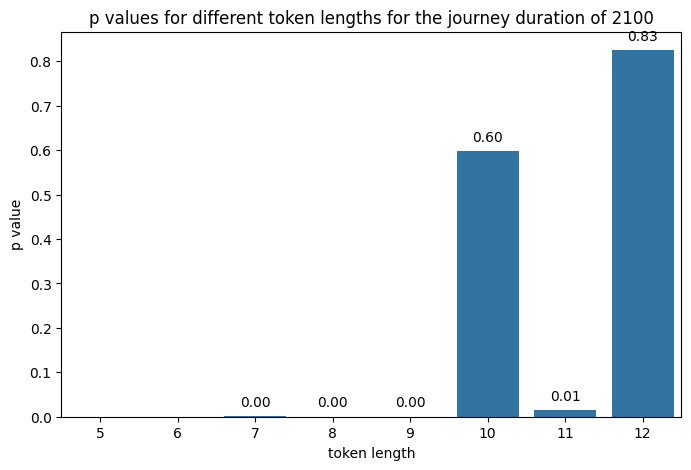

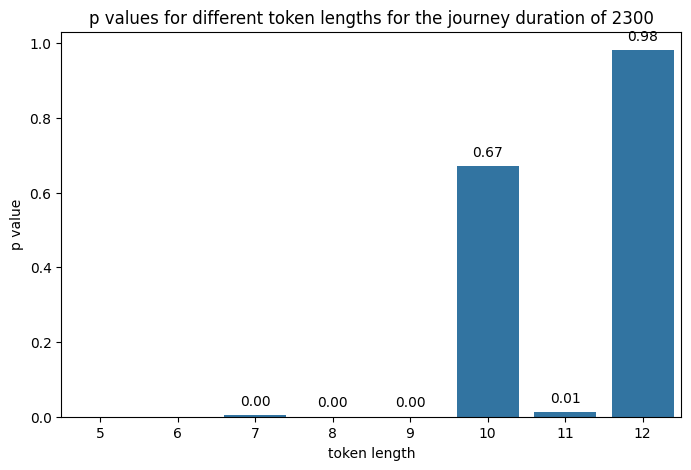

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns


for duration in list(range(30, 150, 30)) + list(range(150, 500, 50)) + list(range(500, 1500, 100)) + list(range(1500, 2500, 200)):
    f, ax = plt.subplots(1, 1, figsize=(8, 5))

    sns.barplot(plotDf[plotDf['journey duration'] == duration], x='token length', y='p value',  ax=ax)

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    ax.set_title('p values for different token lengths for the journey duration of ' + str(duration))

    plt.show()

### Combined heatmap

In [9]:
heatmapDf = plotDf.pivot_table(index='token length',columns='journey duration', values='p value', aggfunc='mean')
heatmapDf

journey duration,30,60,90,120,150,200,250,300,350,400,...,1000,1100,1200,1300,1400,1500,1700,1900,2100,2300
token length,,,,,,,,,,,,,,,,,,,,,
7,6.410431e-01,1.292563e-03,0.000691,1.971195e-04,0.000008,0.000004,5.346009e-07,2.217285e-07,0.030742,6.366542e-05,...,0.055575,0.126372,0.070189,0.019630,0.010545,0.005360,0.000553,0.000119,1.300368e-03,3.894316e-03
8,9.495311e-01,1.730702e-04,0.000081,8.176278e-01,0.706063,0.597720,9.174976e-02,4.123066e-02,0.001560,5.634564e-10,...,0.370773,0.043220,0.019182,0.003627,0.003494,0.000692,0.000899,0.000044,6.914849e-06,2.896026e-06
9,3.259966e-01,4.621438e-03,0.124003,2.237597e-01,0.048969,0.338729,9.040947e-01,1.746483e-01,0.534218,2.891540e-02,...,0.055008,0.047822,0.000502,0.000007,0.000023,0.000003,0.000002,0.000012,3.236030e-07,5.698559e-08
10,6.441874e-08,1.115528e-07,0.000006,2.736985e-02,0.003985,0.037667,6.441633e-04,4.921009e-05,0.006808,1.993595e-02,...,0.080493,0.097677,0.016149,0.198034,0.161317,0.183033,0.221051,0.188436,5.978010e-01,6.719941e-01
11,5.194296e-01,7.652989e-05,0.001724,2.907434e-08,0.723573,0.446116,6.837375e-01,2.481045e-02,0.016461,8.394024e-10,...,0.017844,0.124569,0.333658,0.143117,0.259145,0.307468,0.190596,0.040147,1.464077e-02,1.153211e-02
12,5.194296e-01,7.652989e-05,0.013060,1.734991e-03,0.714550,0.848813,1.604074e-01,9.121823e-02,0.772192,7.095879e-08,...,0.316141,0.172860,0.242682,0.303791,0.185729,0.196453,0.287821,0.493495,8.253302e-01,9.820174e-01


[Text(0.5, 25.722222222222214, 'Duration'),
 Text(158.22222222222223, 0.5, 'Minimum token length')]

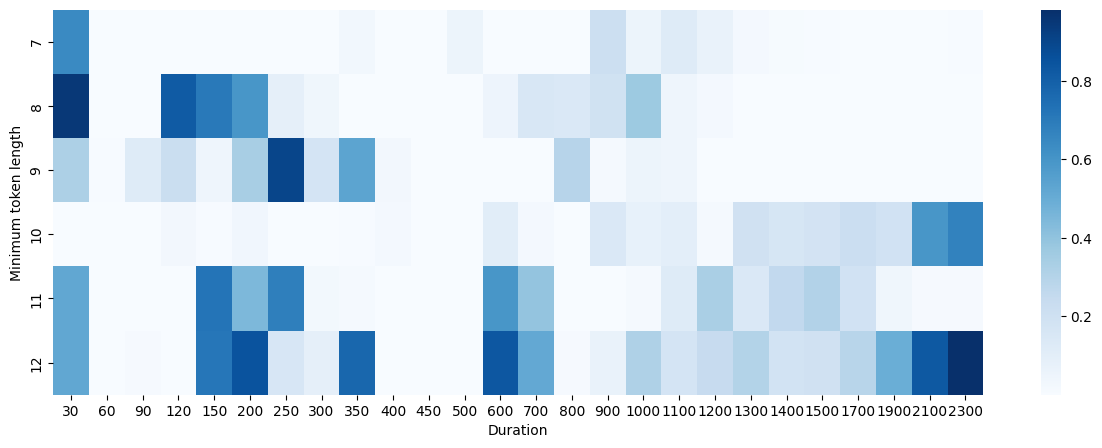

In [10]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(15, 5))

ax = sns.heatmap(
    heatmapDf,
    # annot=True,
    # fmt=".2f",
    cmap="Blues",
    # vmin=0.6,
    # vmax=0.9,
    # yticklabels=['0', '1', '2'],
    # xticklabels=['1', '2', '3', '4', '5', '6'],
    
)
ax.set(xlabel='Duration', ylabel='Minimum token length')

[Text(0.5, 25.722222222222214, 'Duration'),
 Text(158.22222222222223, 0.5, 'Minimum token length')]

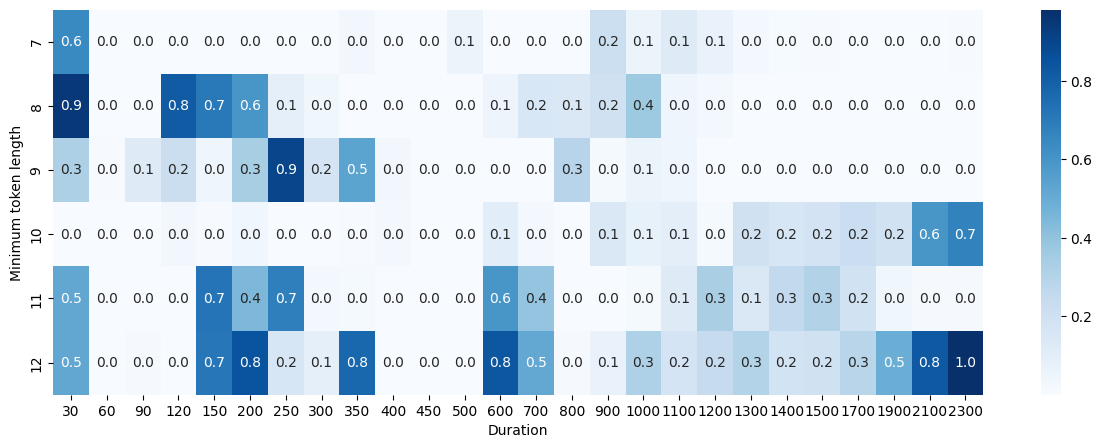

In [11]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(15, 5))

ax = sns.heatmap(
    heatmapDf,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    # vmin=0.6,
    # vmax=0.9,
    # yticklabels=['0', '1', '2'],
    # xticklabels=['1', '2', '3', '4', '5', '6'],
    
)
ax.set(xlabel='Duration', ylabel='Minimum token length')

In [12]:
plotDf['significant'] = plotDf['p value'] > 0.05
heatmapDf = plotDf.pivot_table(index='token length',columns='journey duration', values='significant')
heatmapDf

journey duration,30,60,90,120,150,200,250,300,350,400,...,1000,1100,1200,1300,1400,1500,1700,1900,2100,2300
token length,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
11,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
12,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


[Text(0.5, 25.722222222222214, 'Duration'),
 Text(158.22222222222223, 0.5, 'Significant')]

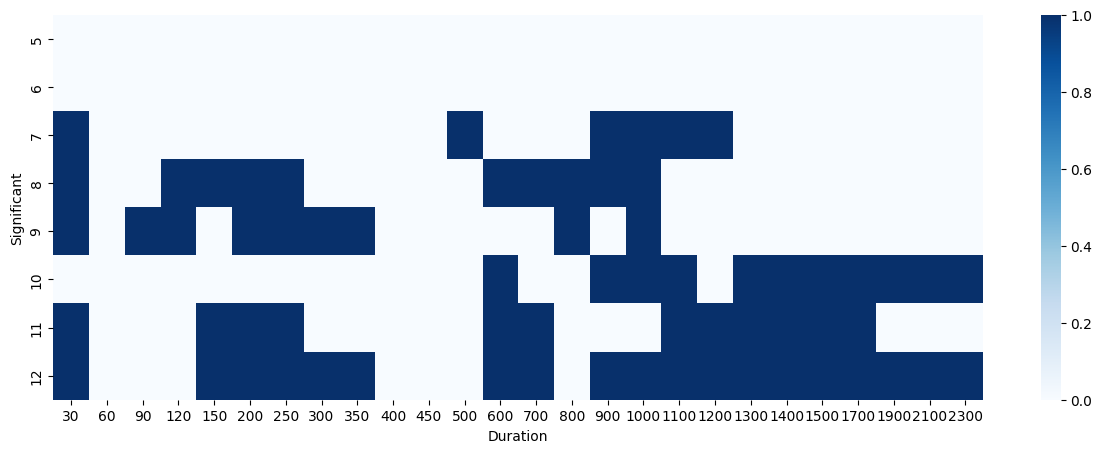

In [13]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(15, 5))

ax = sns.heatmap(
    heatmapDf,
    # annot=True,
    # fmt=".1f",
    cmap="Blues",
    # vmin=0.6,
    # vmax=0.9,
    # yticklabels=['0', '1', '2'],
    # xticklabels=['1', '2', '3', '4', '5', '6'],
    
)
ax.set(xlabel='Duration', ylabel='Significant')